In [2]:
import os
import myCudaModule as mcm
import linAlgebraModule as linalg
import scipy.misc as scm
import scipy.ndimage as scnd
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure as skex
import time
import pycuda.driver as drv
import pycuda.tools as tl
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import sys
import time

Loading the images:

In [3]:
%matplotlib auto
image = scm.imread('/home/amr62/Documents/TheEffingPhDHatersGonnaHate/fastmsToying/trialimages/curve3.jpg').astype(np.float32)
#image = mcm.grayfication(image)
image  = 1- scnd.gaussian_filter(image[:,:,1],2)/255
image[(image<0.5).nonzero()]=0
image[image.nonzero()]=1
plt.imshow(image,cmap='Greys_r')


Using matplotlib backend: TkAgg


Function that finds the inside of the curve

In [4]:
arr=np.array(((1-image[25,:]).nonzero()))
larr    = np.size(arr)
trueArr = np.array((arr[0,0]))
trueArr








array(0)

In [5]:
def curveInterior(image):
    forme = image.shape
    if(np.size(forme)>2):
        sys.exit('Only works on gray images')
    

    aSize    = forme[0]*forme[1]
    xdim     = np.int32(forme[0])
    ydim     = np.int32(forme[1])   
    labIm    = np.zeros(forme)    
    
    for i in range(0,xdim):
        arr     = np.array(((image[i,:]).nonzero()))
        larr    = np.size(arr)
        if(larr>0):
            trueArr = np.array((arr[0,0]))
            #print('larr='+str(larr))
            for k in range(1,larr):
                #print(k)
                if(arr[0,k]-arr[0,k-1]>1 ): trueArr =  np.append(trueArr,arr[0,k])
            N = np.size(trueArr)
            
            for l in range(0,N-1):
                if(l%2==0): labIm[i,:][trueArr[l]:trueArr[l+1]]=1
                    
    for j in range(0,ydim):
        arr     = np.array(((image[:,j]).nonzero()))
        larr    = np.size(arr)
        if(larr>0):
            trueArr = np.array((arr[0,0]))
            #print('larr='+str(larr))
            for k in range(1,larr):
                #print(k)
                if(arr[0,k]-arr[0,k-1]>1 ): trueArr =  np.append(trueArr,arr[0,k])
            N = np.size(trueArr)
            
            for l in range(0,N-1):
                if(l%2==0): labIm[:,j][trueArr[l]:trueArr[l+1]]=1
                #print('we in there'+str(l))
    return labIm
"""    
    for j in range(1,ydim):
            if(labIm[i,j-1]!=0): 
                labIm[i,j]=image[i,j-1]
            else:
                if(image[i-1,j]!=0):
                    labIm[i,j]=image[i-1,j]
                else:
                    Nlab       = Nlab+1
                    labIm[i,j] = Nlab
    for j in range(0,ydim):
        arr     = (1-image[:,j]).nonzero()
        if(np.size(arr)!=0):        
            maxind  = np.max(arr)
            minind  = np.min(arr)
            labIm[:,j][minind:maxind] = 0
"""                        
    
%matplotlib auto
labIm                      = curveInterior(image)
plt.imshow(labIm)
#plt.hist(labIm.ravel())

Using matplotlib backend: TkAgg


DIstance transform that uses the interior labels to set neagtive distances

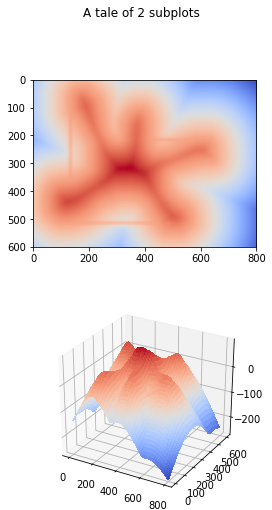

In [7]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
dist                       = scnd.morphology.distance_transform_edt(1-image).astype(np.float32)
dist[(1-labIm).nonzero()]  = -dist[(1-labIm).nonzero()]
#np.loadtxt('/home/amr62/Documents/TheEffingPhDHatersGonnaHate/fastmsToying/trialimages/distance.dat',delimiter=',').astype(np.float32)
#dist = dist/(np.max(dist)-np.min(dist))
dist = scnd.gaussian_filter(dist,6)




fig = plt.figure(figsize=plt.figaspect(2.))
fig.suptitle('A tale of 2 subplots')
ax0 = fig.add_subplot(2, 1, 1)
l   = ax0.imshow(dist,cmap='coolwarm')

ax = fig.add_subplot(2, 1, 2, projection='3d')


# Make data.
xdim = image.shape[0]
ydim = image.shape[1]
Y = np.arange(0, xdim, 1)
X = np.arange(0,ydim, 1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = dist

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap = 'coolwarm',
                       linewidth=0, antialiased=False)

# Customize the z axis.


# Add a color bar which maps values to colors.


plt.show()

(-0.5, 799.5, 599.5, -0.5)

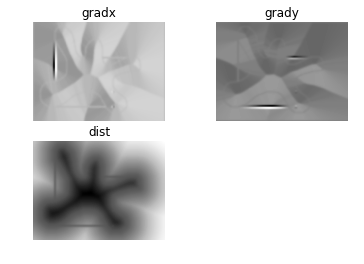

In [135]:
%matplotlib inline
grady, gradx = np.gradient(dist)

gradx[:,ydim-1] = dist[:,ydim-1] -dist[:,ydim-2]
gradx[:,0]      =  dist[:,1]-dist[:,0]
    

grady[xdim-1,:] = dist[xdim-1,:] -dist[xdim-2,:] 
grady[0,:]      = dist[1,:] - dist[0,:]



colmap = 'Greys'
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(gradx,cmap=colmap)
ax0.set_title('gradx')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(grady,cmap=colmap)
ax1.set_title('grady')
ax1.axis('off')


ax2 = fig2.add_subplot(223)
ax2.imshow(dist,cmap=colmap)
ax2.set_title('dist')
ax2.axis('off')



3d plots of gradients

Using matplotlib backend: TkAgg


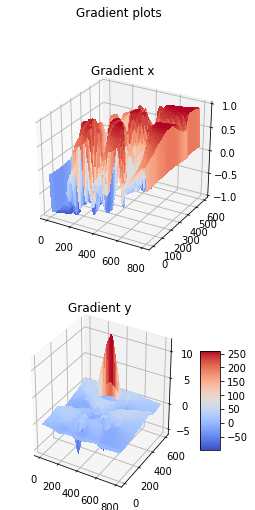

In [34]:
%matplotlib auto


# Make data.
Z    = gradx
xdimz = Z.shape[0]
ydimz = Z.shape[1]
Y = np.arange(0, xdimz, 1)
X = np.arange(0,ydimz, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.

# Customize the z axis.


fig   = plt.figure(figsize=plt.figaspect(2.))
fig.suptitle('Gradient plots')
ax0   = fig.add_subplot(2, 1, 1,projection='3d')
ax0.set_title('Gradient x')
surf0 = ax0.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.




Z    = grady
xdimz = Z.shape[0]
ydimz = Z.shape[1]
Y = np.arange(0, xdimz, 1)
X = np.arange(0,ydimz, 1)
X, Y = np.meshgrid(X, Y)

ax1 = fig.add_subplot(2, 1, 2, projection='3d')
ax1.set_title('Gradient y')
surf1 = ax1.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()





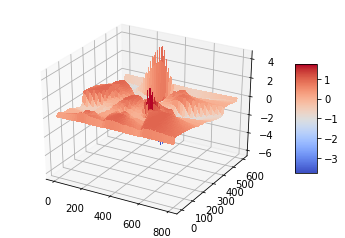

In [136]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
Z    = grady
xdimz = Z.shape[0]
ydimz = Z.shape[1]
Y = np.arange(0, xdimz, 1)
X = np.arange(0,ydimz, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)

# Customize the z axis.



# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

boundary values need fixing

In [137]:
shupright   = np.zeros((xdim,ydim))
shupleft    = np.zeros((xdim,ydim))
shdownright = np.zeros((xdim,ydim))
shdownleft  = np.zeros((xdim,ydim))
shleft      = np.zeros((xdim,ydim))
shright     = np.zeros((xdim,ydim))
shdown      = np.zeros((xdim,ydim))
shup        = np.zeros((xdim,ydim))
div         = np.zeros((xdim,ydim))
final       = 1*dist

maxit       = 22000

timestep    = 0.5

for k in range(0,maxit):
    shupright[0:(xdim-2),0:(ydim-2)]    = final[1:(xdim-1),1:(ydim-1)] #shdupright(i,j)  = image(i+1,j+1)                 
    shupleft[1:(xdim-1),0:(ydim-2)]     = final[0:(xdim-2),1:(ydim-1)] # shupleft(i,j)   = image(i-1,j+1)
    shdownright[0:(xdim-2),1:(ydim-1)]  = final[1:(xdim-1),0:(ydim-2)] #shdownright(i,j) = image(i+1,j-1)
    shdownleft[1:(xdim-1),1:(ydim-1)]   = final[0:(xdim-2),0:(ydim-2)] # shdownleft(i,j)  = image(i-1,j-1)
    shdown[1:(xdim-1),:]  = final[0:(xdim-2),:] #shdown: shdown(i,j) = image(i-1,j)
    shup[0:(xdim-2),:]    = final[1:(xdim-1),:] #shup: shup(i,j) = image(i+1,j)
    shright[:,0:(ydim-2)] = final[:,1:(ydim-1)] #shright  : shright(i,j)   = image(i,j+1)
    shleft[:,1:(ydim-1)]  = final[:,0:(ydim-2)] #shleft : shleft(i,j) = image(i,j-1)
    
    grady, gradx = np.gradient(final)
    
    normgrad     = gradx**2+grady**2
    
    normgrad[(normgrad<0.0000000001).nonzero()] = 1
    
    gradxx           = shright - 2*final+ shleft
    gradxx[:,ydim-1] = final[:,ydim-1] -2*final[:,ydim-2] + final[:,ydim-3]
    gradxx[:,0]      = final[:,2] -2*final[:,1]+final[:,0]
    
    gradyy           = shup - 2*final + shdown
    gradyy[xdim-1,:] = final[xdim-1,:] -2*final[xdim-2,:] + final[xdim-3,:]
    gradyy[0,:]      = final[2,:]-2*final[1,:] + final[0,:]
    
    gradxy           = (shupright - shupleft - shdownright + shdownleft)/4   
 
    gradxy[0:xdim-2,0] = (final[1:xdim-1,1] - final[0:xdim-2,1] - final[1:xdim-1,0] + final[0:xdim-2,0] )
    gradxy[xdim-1,0]   = (final[xdim-1,1] - final[xdim-2,1] - final[xdim-1,0] + final[xdim-2,0])
    
    gradxy[0:xdim-2,ydim-1] = (final[1:xdim-1,ydim-1] - final[0:xdim-2,ydim-1] - final[1:xdim-1,ydim-2] + final[0:xdim-2,ydim-2])
    gradxy[xdim-1,ydim-1]   = (final[xdim-1,ydim-1] - final[xdim-2,ydim-1] - final[xdim-1,ydim-2] + final[xdim-2,ydim-2])
    
    gradxy[0,1:ydim-2]      = (final[1,2:ydim-1] - final[0,2:ydim-1] - final[1,1:ydim-2] + dist[0,1:ydim-2])
    gradxy[xdim-1,1:ydim-2] = (final[xdim-1,2:ydim-1] - final[xdim-2,2:ydim-1] - final[xdim-1,1:ydim-2] + final[xdim-2,1:ydim-2])
    
    
    div    = (gradxx*grady*grady - 2*gradx*grady*gradxy + gradyy*gradx*gradx)/(normgrad)
    div[(normgrad<0.0000000001).nonzero()] = 0
    #div[np.isnan(div)] = 0
    #div[np.isinf(div)] = 0
    final   = timestep*div + final
    
    



In [51]:
%matplotlib qt5
colmap = 'Greys'
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(dist,cmap=colmap)
ax0.set_title('initial conditions')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(final[1:xdim-2,1:ydim-2],cmap=colmap)
ax1.set_title('final state excluding boundary')
ax1.axis('off')


ax2 = fig2.add_subplot(223)
ax2.imshow(final[1:xdim-2,1:ydim-2]-dist[1:xdim-2,1:ydim-2],cmap=colmap)
ax2.set_title('final-dist')
ax2.axis('off')

ax3 = fig2.add_subplot(224)
ax3.imshow(grady,cmap=colmap)
ax3.set_title('grady')
ax3.axis('off')
plt.show()

In [52]:
%matplotlib auto
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
#Z    = final[1:xdim-2,1:ydim-2]
#Z     = final[1:xdim-2,1:ydim-2]
Z      = div[10:xdim-20,10:ydim-20]
#Z     = final
xdimz = Z.shape[0]
ydimz = Z.shape[1]
Y = np.arange(0, xdimz, 1)
X = np.arange(0,ydimz, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)

# Customize the z axis.



# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Using matplotlib backend: TkAgg


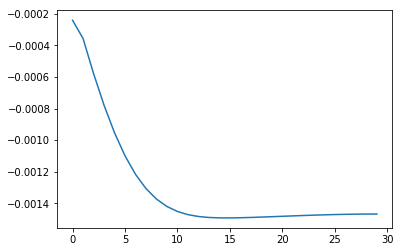

In [110]:
plt.plot(gradx[0,0:30])

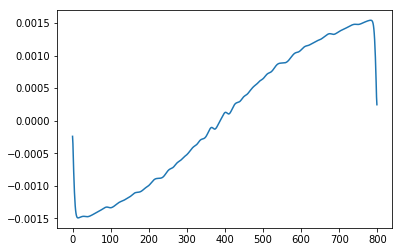

In [105]:
plt.plot(gradx[0,:])


In [36]:
plt.plot(final[0,0:30])

    Function that finds the curve from a level set function array

(-0.5, 799.5, 599.5, -0.5)

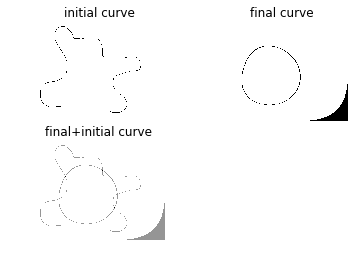

In [53]:
#==============================================================
def findZeros(dist,tol):
    forme = dist.shape
    dimI  = forme[0]
    dimJ  = forme[1]
    
    
    dist       = np.reshape(dist,dimI*dimJ,order = 'F')
    curveArray = np.zeros(dimI*dimJ)
    
    for k in range(0,dimI*dimJ):
        if(dist[k]**2<tol):
            curveArray[k] = 1
            
    curveArray = np.reshape(curveArray,forme,order='F')
    return curveArray
#===============================================================
    
curveInit  = findZeros(dist,0.7)
curveFinal =  findZeros(final,0.5)
    
%matplotlib inline
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(curveInit,cmap=colmap)
ax0.set_title('initial curve')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(curveFinal,cmap=colmap)
ax1.set_title('final curve')
ax1.axis('off')    
    
ax2 = fig2.add_subplot(223)
ax2.imshow(curveFinal+curveInit,cmap=colmap)
ax2.set_title('final+initial curve')
ax2.axis('off') 

In [15]:
0%2

0